# Building hierarchical model with YOLO

In [2]:
#Mount drive to access files in gdrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#extracting the train image directory
!unzip drive/My\ Drive/PROJECT/train2014.zip 

Streaming output truncated to the last 5000 lines.
 extracting: train2014/COCO_train2014_000000408557.jpg  
 extracting: train2014/COCO_train2014_000000013714.jpg  
 extracting: train2014/COCO_train2014_000000194043.jpg  
 extracting: train2014/COCO_train2014_000000219859.jpg  
 extracting: train2014/COCO_train2014_000000278135.jpg  
 extracting: train2014/COCO_train2014_000000141015.jpg  
 extracting: train2014/COCO_train2014_000000280923.jpg  
 extracting: train2014/COCO_train2014_000000200024.jpg  
 extracting: train2014/COCO_train2014_000000435713.jpg  
 extracting: train2014/COCO_train2014_000000249993.jpg  
 extracting: train2014/COCO_train2014_000000424160.jpg  
 extracting: train2014/COCO_train2014_000000142761.jpg  
 extracting: train2014/COCO_train2014_000000532668.jpg  
 extracting: train2014/COCO_train2014_000000564904.jpg  
 extracting: train2014/COCO_train2014_000000346384.jpg  
 extracting: train2014/COCO_train2014_000000560934.jpg  
 extracting: train2014/COCO_train2014

In [3]:
!pip install yolov4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 534 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for yolov4: filename=yolov4-3.2.0-cp37-cp37m-linux_x86_64.whl size=140574 sha256=63879ca1fdda8692d823aa5225cfdf04ea58a3996c483568aa6779a969e4a320
  Stored in directory: /root/.cache/pip/wheels/2f/b0/9a/cb8f2f279a59c0e8c874074df1333645b33f2f9c3cb58498de
Successfully built yolov4


In [6]:
#importing libraries

import json
import pickle
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import heapq
import random as rn
import warnings
warnings.filterwarnings("ignore")
import scipy.io
import gc
from time import time
from tqdm import tqdm
from datetime import datetime
from collections import defaultdict
import operator
from itertools import zip_longest
from scipy.sparse import hstack
import matplotlib.image as mpimg
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19 
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers 
import tensorflow.keras.backend as k
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint,TensorBoard,ReduceLROnPlateau,History,LearningRateScheduler
from tensorflow.keras.regularizers import l1,l2,l1_l2
import tensorflow.keras
from tensorflow.keras.models import model_from_json, Model,Sequential, load_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer,one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import LSTM,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,SpatialDropout1D,Input
from tensorflow.keras.layers import BatchNormalization,Conv2D,Conv1D, Multiply, Activation

In [5]:
#Yolov4 implementation

from yolov4.tf import YOLOv4
import cv2
import time
import numpy as np
import tensorflow as tf

def partition(arr, low, high): 
    i = (low - 1)  # index of smaller element 
    pivot = arr[high]  # pivot 

    for j in range(low, high): 

        # If current element is smaller than or 
        # equal to pivot 
        if arr[j][6] >= pivot[6]:  # the width of the box times the height of the box times the confidence rate # hadie

            # increment index of smaller element 
            i = i + 1
            arr[i], arr[j] = arr[j], arr[i] 

    arr[i + 1], arr[high] = arr[high], arr[i + 1] 
    return (i + 1) 

def quickSort(arr, low, high): 
    if len(arr) == 1: 
        return arr 
    if low < high: 

        # pi is partitioning index, arr[p] is now 
        # at right place 
        pi = partition(arr, low, high) 

        # Separately sort elements before 
        # partition and after partition 
        quickSort(arr, low, pi - 1) 
        quickSort(arr, pi + 1, high) 
        
        
yolo = YOLOv4()
yolo.config.parse_names("/content/drive/MyDrive/PROJECT/coco.names")
yolo.config.parse_cfg("/content/drive/MyDrive/PROJECT/yolov4.cfg")
yolo.make_model()
yolo.load_weights("/content/drive/MyDrive/PROJECT/yolov4.weights", weights_type="yolo")

# the output is sorted according to the area by confidence
def image_path_to_yolo_bounding_boxes(image_path):  
    frame = cv2.imread(image_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    bboxes = yolo.predict(frame, prob_thresh=0.25)
    bboxes = bboxes.tolist()
    n = len(bboxes)
    # for each bounding box, append (area * confidence)
    for i in range(n):
        bboxes[i].append(bboxes[i][2] * bboxes[i][3] * bboxes[i][5])
    quickSort(bboxes, 0, n - 1)
    bboxes = np.array(bboxes)
    return bboxes

Call tf.config.experimental.set_memory_growth(GPU0, True)


In [ ]:
#the train dataset

data = pd.read_csv('/content/drive/MyDrive/PROJECT/train_data.csv')
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data

,im_path,question,answer
0,train2014/COCO_train2014_000000458752.jpg,what is this photo taken looking through?,net
1,train2014/COCO_train2014_000000458752.jpg,what position is this man playing?,pitcher
2,train2014/COCO_train2014_000000458752.jpg,what color is the players shirt?,orange
3,train2014/COCO_train2014_000000458752.jpg,is this man a professional baseball player?,yes
4,train2014/COCO_train2014_000000262146.jpg,what color is the snow?,white
...,...,...,...
388247,train2014/COCO_train2014_000000524286.jpg,how many keyboards are there?,2
388248,train2014/COCO_train2014_000000524286.jpg,what color is the keyboard?,black
388249,train2014/COCO_train2014_000000524286.jpg,is there a computer mouse on the desk?,no
388250,train2014/COCO_train2014_000000524286.jpg,what color is the computer?,black


In [ ]:
#reading the xtrain, ytrain, xtest and ytest csv files

x_train=pd.read_csv('/content/drive/MyDrive/PROJECT/x_train.csv')
x_train.drop(['Unnamed: 0'],axis=1,inplace=True)

x_test=pd.read_csv('/content/drive/MyDrive/PROJECT/x_test.csv')
x_test.drop(['Unnamed: 0'],axis=1,inplace=True)

y_train=pd.read_csv('/content/drive/MyDrive/PROJECT/y_train.csv')
y_train.drop(['Unnamed: 0'],axis=1,inplace=True)

y_test=pd.read_csv('/content/drive/MyDrive/PROJECT/y_test.csv')
y_test.drop(['Unnamed: 0'],axis=1,inplace=True)

In [ ]:
print("X_train shape:", x_train.shape)
print("Y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (271776, 3)
Y_train shape: (271776, 1)
X_test shape: (116476, 3)
Y_test shape: (116476, 1)


# Creating image features

In [7]:
#Initialize xception and load the pretrained Imagenet weights
def xception():
    model = tf.keras.applications.Xception(include_top=False, weights='imagenet')
    new_input = model.input
    hidden_layer = model.layers[-1].output
    model = Model(new_input, hidden_layer)
    return model

#Using xception
def parse_function(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, image_path

In [ ]:
#Caching the features extracted from xception
#get unique images
img_fl = sorted(set(data['im_path'].unique()))
img_data_tr = tf.data.Dataset.from_tensor_slices(img_fl)
img_data_tr = img_data_tr.map(parse_function,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
feature_model = xception()

for img, path in tqdm(img_data_tr):
    batch_features = feature_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        yolo_features = image_path_to_yolo_bounding_boxes(path_of_feature) 
        yolo_features = np.array(yolo_features.flatten()) 
        yolo_features = np.pad(yolo_features, (0, 2048 - yolo_features.shape[0]), 'constant', constant_values=(0, 0)).astype(np.float32)  
        combined_features = np.vstack((bf.numpy(), yolo_features)).astype(np.float32)  
        np.save(path_of_feature, combined_features) 

83697664/83683744 [==============================] - 1s 0us/step


100%|██████████| 2581/2581 [1:08:08<00:00,  1.58s/it]


# Creating text features

In [ ]:
#tokenization
tokenizer = Tokenizer(oov_token = "<unk>", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(x_train['question'].values)
train_question_seqs = tokenizer.texts_to_sequences(x_train['question'].values)
val_question_seqs = tokenizer.texts_to_sequences(x_test['question'].values)

ques_train = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding='post')
ques_test = tf.keras.preprocessing.sequence.pad_sequences(val_question_seqs, padding = 'post', maxlen = input_shape)

print("Number of words in tokenizer:", len(tokenizer.word_index))
ques_vocab = tokenizer.word_index
input_shape = ques_train.shape[1]

Number of words in tokenizer: 11594


In [ ]:
#label encoding the class labels for multi class classification

label_encoder = LabelBinarizer()
answ_train = label_encoder.fit_transform(x_train['answer'].apply(lambda x: x).values)
answ_test = label_encoder.transform(x_test['answer'].apply(lambda x: x).values)

#no of classes
ans_vocab = {l: i for i, l in enumerate(label_encoder.classes_)}

print("Number of clasess: ", len(ans_vocab))
print("Shape of Answer Vectors in Train Data: ", answ_train.shape)
print("Shape of Answer Vectors in Validation Data: ", answ_test.shape)

Number of clasess:  1000
Shape of Answer Vectors in Train Data:  (271776, 1000)
Shape of Answer Vectors in Validation Data:  (116476, 1000)


In [ ]:
#saving the required variable as pickle files, later required while testing

with open('/content/drive/MyDrive/PROJECT/tokenizer_y.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/PROJECT/ques_vocab_y.pickle', 'wb') as handle:
    pickle.dump(ques_vocab, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/content/drive/MyDrive/PROJECT/input_shape_y.pickle', 'wb') as handle:
    pickle.dump(input_shape, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/PROJECT/label_encoder_y.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/content/drive/MyDrive/PROJECT/ans_vocab_y.pickle', 'wb') as handle:
    pickle.dump(ans_vocab, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Creating Datasets

In [ ]:
#function to load the numpy files
def map_func(img_name, question):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    img_tensor = np.reshape(img_tensor,(-1,img_tensor.shape[-1]))
    return img_tensor, question

#function to create datasets
def create_dataset(ques, answ, img):
    dataset = tf.data.Dataset.from_tensor_slices((img, ques.astype(np.float32)))
    
    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
              map_func, [item1, item2], [tf.float32, tf.float32]),
              num_parallel_calls=tf.data.experimental.AUTOTUNE)
    op_dataset = tf.data.Dataset.from_tensor_slices(answ.astype(np.float32))
    
    #combining image, question and answer as a single dataset
    dataset = tf.data.Dataset.zip((dataset,op_dataset))
    dataset = dataset.batch(1000)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


img_train = x_train['im_path'].values 
img_test = x_test['im_path'].values

#creating train and test datasets
train_dataset = create_dataset(ques_train, answ_train, img_train)
test_dataset = create_dataset(ques_test, answ_test, img_test)

# Coattention model 

In [8]:
class CoattentionModel(tf.keras.layers.Layer):
    def __init__(self):#, num_embeddings, num_classes, embed_dim=512, k=30
        super().__init__()
        self.num_classes = len(ans_vocab)
        self.hidden_size = 512
        self.dropout = 0.3
        self.num_embeddings = len(ques_vocab) + 1

        self.image_dense = Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=15)) 
        self.image_corr = Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=29))

        self.image_atten_dense = Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=17)) 
        self.question_atten_dens = Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=28))
        self.question_atten_dropout = Dropout(self.dropout)
        self.image_atten_dropout = Dropout(self.dropout)

        self.ques_atten = Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=21))

        self.img_atten = Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=33))

        self.embed = Embedding(self.num_embeddings, self.hidden_size,
                                               embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))
        
        self.unigram_conv = Conv1D(filters = self.hidden_size, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=41))
        self.bigram_conv  = Conv1D(filters = self.hidden_size, kernel_size = 2, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=58), dilation_rate = 2)
        self.trigram_conv = Conv1D(filters = self.hidden_size, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=89), dilation_rate = 2)
        self.max_pool = MaxPool2D((3,1))
        self.phrase_dropout = Dropout(self.dropout)
        
        self.lstm = LSTM(units = 512 , return_sequences=True, dropout = self.dropout,
                                         kernel_initializer = tf.keras.initializers.glorot_uniform(seed=26),
                                         recurrent_initializer = tf.keras.initializers.orthogonal(seed=54))
        
        self.tanh = Activation('tanh')
        self.softmax = Activation('softmax')
        
        self.W_w_dropout = Dropout(self.dropout)
        self.W_p_dropout = Dropout(self.dropout)
        self.W_s_dropout = Dropout(self.dropout)

        self.W_w = Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=32), input_shape = (self.hidden_size,))
        self.W_p = Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=49), input_shape = (2 * self.hidden_size, ))
        self.W_s = Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=31), input_shape = (2 * self.hidden_size, ))
        
        self.fc1_Dense = Dense(units = 2 * self.hidden_size, activation='relu',
                                               kernel_initializer = tf.keras.initializers.he_normal(seed=84))
        self.fc1_dropout = Dropout(self.dropout)

        self.fc = Dense(units = self.num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.glorot_uniform(seed=91), input_shape = (self.hidden_size,))
        
        return

    def call(self, image, question):#Image: B x 101 x 2048
        
        image = self.image_dense(image)
        image = self.tanh(image)

        words = self.embed(question)    # Words: B x L x 512

        unigrams =  tf.expand_dims(self.tanh(self.unigram_conv(words)), 1) # B x L x 512
        bigrams  =  tf.expand_dims(self.tanh(self.bigram_conv(words)), 1)  # B x L x 512
        trigrams =  tf.expand_dims(self.tanh(self.trigram_conv(words)), 1) # B x L x 512

        phrase = tf.squeeze(self.max_pool(tf.concat((unigrams, bigrams, trigrams), 1)), axis=1)  # B x L x 512
        phrase = self.tanh(phrase)
        phrase = self.phrase_dropout(phrase)
  
        hidden = None
        sentence = self.lstm(phrase)        # B x L x 512   

        v_word, q_word = self.co_attention(image, words)
        v_phrase, q_phrase = self.co_attention(image, phrase)
        v_sent, q_sent = self.co_attention(image, sentence)

        h_w = self.tanh(self.W_w(self.W_w_dropout(q_word + v_word)))
        h_p = self.tanh(self.W_p(self.W_p_dropout(tf.concat(((q_phrase + v_phrase), h_w), axis=1))))
        h_s = self.tanh(self.W_s(self.W_s_dropout(tf.concat(((q_sent + v_sent), h_p), axis=1))))

        fc1 = self.fc1_Dense(self.fc1_dropout(h_s))
        logits = self.fc(fc1)

        return logits

    def co_attention(self, img_feat, ques_feat):  # V : B x 2048 x 101, Q : B x L x 512
        img_corr = self.image_corr(img_feat)

        weight_matrix = tf.keras.backend.batch_dot(ques_feat, img_corr, axes = (2, 2))
        weight_matrix = self.tanh(weight_matrix)

        ques_embed = self.image_atten_dense(ques_feat)
        img_embed = self.question_atten_dens(img_feat)

        transform_img = tf.keras.backend.batch_dot(weight_matrix, img_embed)

        ques_atten_sum = self.tanh(transform_img + ques_embed)
        ques_atten_sum = self.question_atten_dropout(ques_atten_sum)
        ques_atten = self.ques_atten(ques_atten_sum)
        ques_atten =  tf.keras.layers.Reshape((ques_atten.shape[1],))(ques_atten)
        ques_atten =  self.softmax(ques_atten)

        # atten for image feature
        transform_ques = tf.keras.backend.batch_dot(weight_matrix, ques_embed, axes = (1, 1))
        img_atten_sum = self.tanh(transform_ques+img_embed)
        img_atten_sum = self.image_atten_dropout(img_atten_sum)
        img_atten = self.img_atten(img_atten_sum)
        img_atten = tf.keras.layers.Reshape((img_atten.shape[1],))(img_atten)
        img_atten = self.softmax(img_atten)

        ques_atten = tf.keras.layers.Reshape(( 1, ques_atten.shape[1]))(ques_atten)
        img_atten = tf.keras.layers.Reshape(( 1, img_atten.shape[1]))(img_atten)

        ques_atten_feat = tf.keras.backend.batch_dot(ques_atten,ques_feat)
        ques_atten_feat = tf.keras.layers.Reshape(( ques_atten_feat.shape[-1],))(ques_atten_feat)

        img_atten_feat =  tf.keras.backend.batch_dot(img_atten, img_feat)
        img_atten_feat = tf.keras.layers.Reshape((img_atten_feat.shape[-1],))(img_atten_feat)

        return img_atten_feat, ques_atten_feat

In [ ]:
def scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

def callBacksList():
    """
    returns list of callback's
    """
    filepath = "/content/drive/MyDrive/PROJECT/Model_Coattention_YOLO_40_1.hdf5"
    checkpoint = ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'auto')
    #reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2)
    #scheduler_lr = LearningRateScheduler(scheduler, verbose=0 )
    
    history = History()
    callbacks_list = [history, checkpoint]
    return callbacks_list

In [9]:
def Build_CoattentionModel():

    image_input = Input(shape =(101, 2048))
    question_input = Input(shape=(input_shape,))
    output = CoattentionModel()(image_input,question_input)
    model = Model(inputs = [image_input, question_input], outputs = output)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
tf.keras.backend.clear_session()
model = Build_CoattentionModel()
model.fit(train_dataset, epochs = 40, validation_data = test_dataset, callbacks = callBacksList())

Epoch 1/40
272/272 [==============================] - ETA: 0s - loss: 3.5524 - accuracy: 0.2532
Epoch 1: val_accuracy improved from -inf to 0.28669, saving model to /content/drive/MyDrive/PROJECT/Model_Coattention_YOLO_40_1.hdf5
272/272 [==============================] - 1961s 7s/step - loss: 3.5524 - accuracy: 0.2532 - val_loss: 2.9467 - val_accuracy: 0.2867
Epoch 2/40
272/272 [==============================] - ETA: 0s - loss: 2.8491 - accuracy: 0.2918
Epoch 2: val_accuracy improved from 0.28669 to 0.31995, saving model to /content/drive/MyDrive/PROJECT/Model_Coattention_YOLO_40_1.hdf5
272/272 [==============================] - 2236s 8s/step - loss: 2.8491 - accuracy: 0.2918 - val_loss: 2.5978 - val_accuracy: 0.3199
Epoch 3/40
272/272 [==============================] - ETA: 0s - loss: 2.5400 - accuracy: 0.3217
Epoch 3: val_accuracy improved from 0.31995 to 0.34634, saving model to /content/drive/MyDrive/PROJECT/Model_Coattention_YOLO_40_1.hdf5
272/272 [==============================] 

# Testing

In [10]:
!unzip drive/My\ Drive/PROJECT/val2014.zip 

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000535608.jpg  
 extracting: val2014/COCO_val2014_000000279145.jpg  
 extracting: val2014/COCO_val2014_000000243495.jpg  
 extracting: val2014/COCO_val2014_000000225791.jpg  
 extracting: val2014/COCO_val2014_000000428067.jpg  
 extracting: val2014/COCO_val2014_000000059383.jpg  
 extracting: val2014/COCO_val2014_000000558498.jpg  
 extracting: val2014/COCO_val2014_000000376123.jpg  
 extracting: val2014/COCO_val2014_000000191304.jpg  
 extracting: val2014/COCO_val2014_000000171062.jpg  
 extracting: val2014/COCO_val2014_000000014549.jpg  
 extracting: val2014/COCO_val2014_000000121152.jpg  
 extracting: val2014/COCO_val2014_000000276596.jpg  
 extracting: val2014/COCO_val2014_000000029431.jpg  
 extracting: val2014/COCO_val2014_000000036349.jpg  
 extracting: val2014/COCO_val2014_000000502055.jpg  
 extracting: val2014/COCO_val2014_000000438848.jpg  
 extracting: val2014/COCO_val2014_000000364973.j

In [11]:
test_data = pd.read_csv('/content/drive/MyDrive/PROJECT/val_data.csv')
test_data.drop(['Unnamed: 0'],axis=1,inplace=True)
test_data

,im_path,question,answer
0,val2014/COCO_val2014_000000262148.jpg,where is he looking?,down
1,val2014/COCO_val2014_000000262148.jpg,what are the people in the background doing?,watching
2,val2014/COCO_val2014_000000393225.jpg,is this a creamy soup?,no
3,val2014/COCO_val2014_000000393225.jpg,is this rice noodle soup?,yes
4,val2014/COCO_val2014_000000393225.jpg,what is to the right of the soup?,chopsticks
...,...,...,...
187399,val2014/COCO_val2014_000000524282.jpg,what color is the barricade?,gray
187400,val2014/COCO_val2014_000000524282.jpg,are these women wearing skirts?,yes
187401,val2014/COCO_val2014_000000393212.jpg,what is the main color in the photo?,green
187402,val2014/COCO_val2014_000000393212.jpg,does the arrow point left or right?,left


In [12]:
with open('/content/drive/MyDrive/PROJECT/tokenizer_y.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

with open('/content/drive/MyDrive/PROJECT/ques_vocab_y.pickle', 'rb') as handle:
    ques_vocab = pickle.load(handle)

with open('/content/drive/MyDrive/PROJECT/input_shape_y.pickle', 'rb') as handle:
    input_shape = pickle.load(handle)

with open('/content/drive/MyDrive/PROJECT/label_encoder_y.pickle', 'rb') as handle:
    label_encoder = pickle.load(handle)

with open('/content/drive/MyDrive/PROJECT/ans_vocab_y.pickle', 'rb') as handle:
    ans_vocab = pickle.load(handle)    

In [13]:
tf.keras.backend.clear_session()

model_xc = xception()

model_test = Build_CoattentionModel()
model_test.load_weights("/content/drive/MyDrive/PROJECT/Model_Coattention_YOLO_40_1.hdf5")

83697664/83683744 [==============================] - 1s 0us/step


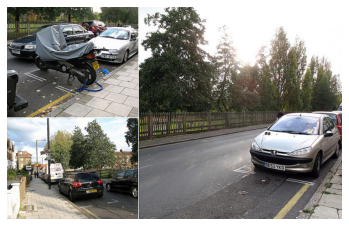

Question : how many license plates are in the photo?
Actual Answer:  5
Top Predicted answers:  [('1', 28.835266), ('0', 27.029598), ('2', 15.465097), ('3', 12.515301), ('4', 5.778471)]
******************************************************************************************************************************************************


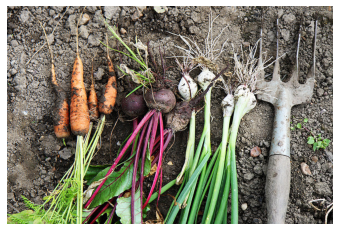

Question : animal, vegetable or mineral?
Actual Answer:  vegetable
Top Predicted answers:  [('carrots', 75.11754), ('carrot', 16.373222), ('bear', 0.97999406), ('leaves', 0.86271137), ('none', 0.55182683)]
******************************************************************************************************************************************************


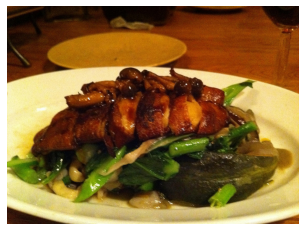

Question : how many plates are in the picture?
Actual Answer:  2
Top Predicted answers:  [('1', 61.634914), ('2', 28.24313), ('0', 4.897339), ('3', 3.92698), ('4', 0.8049256)]
******************************************************************************************************************************************************


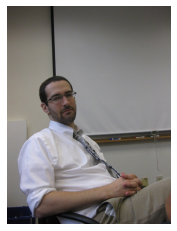

Question : is he ready for work?
Actual Answer:  yes
Top Predicted answers:  [('no', 63.923496), ('yes', 36.07543), ('very', 0.00021709922), ('work', 0.00021492117), ('black and white', 9.3876435e-05)]
******************************************************************************************************************************************************


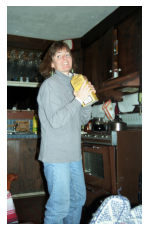

Question : what color are the cabinets?
Actual Answer:  brown
Top Predicted answers:  [('brown', 73.35775), ('white', 11.546919), ('black', 6.5800457), ('gray', 3.9480555), ('tan', 1.2337052)]
******************************************************************************************************************************************************


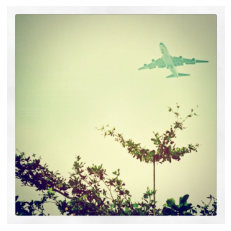

Question : what is in the sky?
Actual Answer:  airplane
Top Predicted answers:  [('plane', 64.58139), ('airplane', 18.991785), ('planes', 4.7443953), ('clouds', 3.2530196), ('birds', 2.5698836)]
******************************************************************************************************************************************************


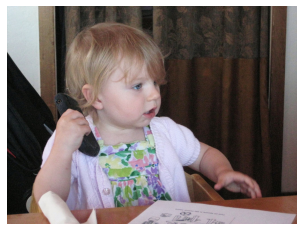

Question : what is the pattern on the baby dress?
Actual Answer:  floral
Top Predicted answers:  [('stripes', 38.862083), ('floral', 24.015574), ('striped', 15.871737), ('solid', 10.352509), ('plaid', 7.8374414)]
******************************************************************************************************************************************************


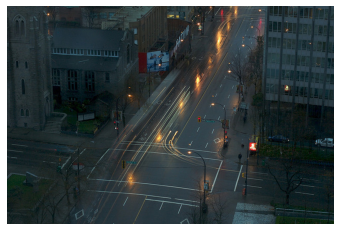

Question : what type of place is this?
Actual Answer:  city
Top Predicted answers:  [('airport', 40.610554), ('skate park', 19.737915), ('city', 14.168772), ('museum', 12.272217), ('apartment', 2.6612525)]
******************************************************************************************************************************************************


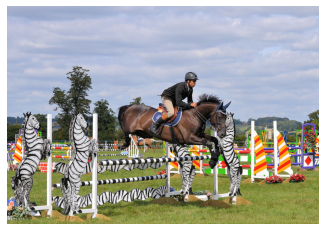

Question : what color are the man pant?
Actual Answer:  tan
Top Predicted answers:  [('white', 25.852531), ('gray', 14.31631), ('blue', 12.15057), ('brown', 11.694966), ('black', 11.669965)]
******************************************************************************************************************************************************


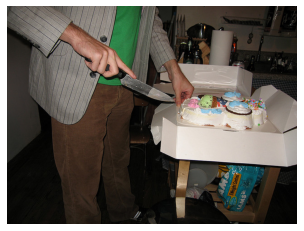

Question : is this likely for a celebration?
Actual Answer:  yes
Top Predicted answers:  [('no', 55.491226), ('yes', 44.507057), ('very', 0.00015211129), ('restaurant', 0.00013933924), ('decoration', 9.770027e-05)]
******************************************************************************************************************************************************


In [22]:

test_idx = np.random.randint(len(test_data), size = 10)

k = 5

for idx in test_idx:
    test_image_id = test_data['im_path'].values[idx]
    test_question = test_data['question'].values[idx]
    actual_answer = test_data['answer'].values[idx]
    
    test_image_features = model_xc(tf.expand_dims(parse_function(test_image_id)[0], 0))
    #print(test_image_features.shape) (1, 10, 10, 2048)
    
    test_image_features = np.reshape(test_image_features,(1, -1,test_image_features.shape[-1]))
    #print(test_image_features.shape) (1, 100, 2048)
    #print(test_image_features[0].shape) (100, 2048)

    yolo_features = image_path_to_yolo_bounding_boxes(test_image_id)  
    yolo_features = np.array(yolo_features.flatten()) 
    #print(yolo_features.shape)  (224,)
    yolo_features = np.pad(yolo_features, (0, 2048 - yolo_features.shape[0]), 'constant', constant_values=(0, 0)).astype(np.float32)  
    #print(yolo_features.shape)    (2048,)
    combined_features = np.vstack((test_image_features[0], yolo_features)).astype(np.float32)
    #print(combined_features.shape) (101, 2048)
    combined_features = combined_features[np.newaxis, :, :]
    #print(combined_features.shape) (1, 101, 2048)
    test_question_features = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([test_question]),padding='post',
                                                                           maxlen=input_shape)
    #print(test_question_features.shape) (1, 22)
    y_pred = model_test.predict([combined_features,test_question_features])

    class_indices = tf.math.top_k(y_pred,k=k).indices.numpy()
    percentages = tf.math.top_k(y_pred,k=k).values.numpy()[0] * 100
    predictions = []
    for idx,i in enumerate(class_indices[0]):
        classes = np.zeros((1,1000))
        classes[0][i] = 1
        predictions.append((label_encoder.inverse_transform(classes)[0],percentages[idx]))

    img = mpimg.imread(test_image_id)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

    print("Question :", test_question)
    print("Actual Answer: ", actual_answer)
    print("Top Predicted answers: ",predictions)
    print("*"*150)


In [23]:
#calculating accuracy of whole test data

actual = []
predictions = []

for idx in tqdm(range(len(test_data))):
    test_image_id = test_data['im_path'].values[idx]
    test_question = test_data['question'].values[idx]
    actual_answer = test_data['answer'].values[idx]
    actual.append(actual_answer)
    
    test_image_features = model_xc(tf.expand_dims(parse_function(test_image_id)[0], 0))
    test_image_features = np.reshape(test_image_features,(1, -1,test_image_features.shape[-1]))

    yolo_features = image_path_to_yolo_bounding_boxes(test_image_id)  
    yolo_features = np.array(yolo_features.flatten()) 
    yolo_features = np.pad(yolo_features, (0, 2048 - yolo_features.shape[0]), 'constant', constant_values=(0, 0)).astype(np.float32)  
    combined_features = np.vstack((test_image_features[0], yolo_features)).astype(np.float32)
    combined_features = combined_features[np.newaxis, :, :]
    test_question_features = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([test_question]),padding='post',
                                                                           maxlen=input_shape)
    y_pred = model_test.predict([combined_features,test_question_features])

    class_indices = tf.math.top_k(y_pred,k=1).indices.numpy()
    classes = np.zeros((1,1000))
    classes[0][class_indices[0]] = 1
    predictions.append((label_encoder.inverse_transform(classes)[0]))

with open('/content/drive/MyDrive/PROJECT/actual_yolo_40_1.pickle', 'wb') as handle:
    pickle.dump(actual, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/PROJECT/predictions_yolo_40_1.pickle', 'wb') as handle:
    pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 187404/187404 [9:53:53<00:00,  5.26it/s]


In [24]:
with open('/content/drive/MyDrive/PROJECT/actual_yolo_40_1.pickle', 'rb') as handle:
    act = pickle.load(handle)

with open('/content/drive/MyDrive/PROJECT/predictions_yolo_40_1.pickle', 'rb') as handle:
    pred = pickle.load(handle)

In [25]:
def accuracy(actual, predictions):
    num_correct = 0
    for i in range(len(actual)):
        if predictions[i] == actual[i]:
            num_correct += 1     
    return (num_correct/ len(actual)) * 100.0 

test_acc = accuracy(act, pred)

print("\nTesting Accuracy of Hierarchical based Attention Model with YOLO:", test_acc)


Testing Accuracy of Hierarchical based Attention Model with YOLO: 45.64843866726431


In [26]:
#Binary class data 

ans = ['yes', 'no']
binary_data = test_data[test_data.answer.isin(ans)].reset_index(drop=True)
binary_data

,im_path,question,answer
0,val2014/COCO_val2014_000000393225.jpg,is this a creamy soup?,no
1,val2014/COCO_val2014_000000393225.jpg,is this rice noodle soup?,yes
2,val2014/COCO_val2014_000000240301.jpg,why is there a gap between the roof and wall?,yes
3,val2014/COCO_val2014_000000240301.jpg,is it daylight in this picture?,yes
4,val2014/COCO_val2014_000000131089.jpg,did the batter hit the ball?,yes
...,...,...,...
80805,val2014/COCO_val2014_000000131063.jpg,was this photo taken at someone house?,yes
80806,val2014/COCO_val2014_000000524280.jpg,is the cat whole body visible?,no
80807,val2014/COCO_val2014_000000524282.jpg,are the players tired?,no
80808,val2014/COCO_val2014_000000524282.jpg,are these women wearing skirts?,yes


In [27]:
#calculating accuracy of whole binary class data 

actual = []
predictions = []

for idx in tqdm(range(len(binary_data))):
    test_image_id = binary_data['im_path'].values[idx]
    test_question = binary_data['question'].values[idx]
    actual_answer = binary_data['answer'].values[idx]
    actual.append(actual_answer)
    
    test_image_features = model_xc(tf.expand_dims(parse_function(test_image_id)[0], 0))
    test_image_features = np.reshape(test_image_features,(1, -1,test_image_features.shape[-1]))

    yolo_features = image_path_to_yolo_bounding_boxes(test_image_id)  
    yolo_features = np.array(yolo_features.flatten()) 
    yolo_features = np.pad(yolo_features, (0, 2048 - yolo_features.shape[0]), 'constant', constant_values=(0, 0)).astype(np.float32)  
    combined_features = np.vstack((test_image_features[0], yolo_features)).astype(np.float32)
    combined_features = combined_features[np.newaxis, :, :]
    test_question_features = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([test_question]),padding='post',
                                                                           maxlen=input_shape)
    y_pred = model_test.predict([combined_features,test_question_features])

    class_indices = tf.math.top_k(y_pred,k=1).indices.numpy()
    classes = np.zeros((1,1000))
    classes[0][class_indices[0]] = 1
    predictions.append((label_encoder.inverse_transform(classes)[0]))

with open('/content/drive/MyDrive/PROJECT/actual_yolo_bi_40.pickle', 'wb') as handle:
    pickle.dump(actual, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/PROJECT/predictions_yolo_bi_40.pickle', 'wb') as handle:
    pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 80810/80810 [4:18:17<00:00,  5.21it/s]


In [28]:
with open('/content/drive/MyDrive/PROJECT/actual_yolo_bi_40.pickle', 'rb') as handle:
    act = pickle.load(handle)

with open('/content/drive/MyDrive/PROJECT/predictions_yolo_bi_40.pickle', 'rb') as handle:
    pred = pickle.load(handle)

def accuracy(actual, predictions):
    num_correct = 0
    for i in range(len(actual)):
        if predictions[i] == actual[i]:
            num_correct += 1     
    return (num_correct/ len(actual)) * 100.0 

test_acc = accuracy(act, pred)

print("\nTesting Accuracy of Hierarchical based Attention Model with YOLO for binary class:", test_acc)


Testing Accuracy of Hierarchical based Attention Model with YOLO for binary class: 55.394134389308256


In [29]:
#Other class data

ans = ['yes', 'no']
other_data = test_data[~test_data.answer.isin(ans)].reset_index(drop=True)
other_data

,im_path,question,answer
0,val2014/COCO_val2014_000000262148.jpg,where is he looking?,down
1,val2014/COCO_val2014_000000262148.jpg,what are the people in the background doing?,watching
2,val2014/COCO_val2014_000000393225.jpg,what is to the right of the soup?,chopsticks
3,val2014/COCO_val2014_000000393226.jpg,what is the man doing in the street?,walking
4,val2014/COCO_val2014_000000393226.jpg,how many photo can you see?,1
...,...,...,...
106589,val2014/COCO_val2014_000000524282.jpg,how many players are there?,2
106590,val2014/COCO_val2014_000000524282.jpg,what game is this?,tennis
106591,val2014/COCO_val2014_000000524282.jpg,what color is the barricade?,gray
106592,val2014/COCO_val2014_000000393212.jpg,what is the main color in the photo?,green


In [30]:
#calculating accuracy of other class data 

actual = []
predictions = []

for idx in tqdm(range(len(other_data))):
    test_image_id = other_data['im_path'].values[idx]
    test_question = other_data['question'].values[idx]
    actual_answer = other_data['answer'].values[idx]
    actual.append(actual_answer)
    
    test_image_features = model_xc(tf.expand_dims(parse_function(test_image_id)[0], 0))
    test_image_features = np.reshape(test_image_features,(1, -1,test_image_features.shape[-1]))

    yolo_features = image_path_to_yolo_bounding_boxes(test_image_id)  
    yolo_features = np.array(yolo_features.flatten()) 
    yolo_features = np.pad(yolo_features, (0, 2048 - yolo_features.shape[0]), 'constant', constant_values=(0, 0)).astype(np.float32)  
    combined_features = np.vstack((test_image_features[0], yolo_features)).astype(np.float32)
    combined_features = combined_features[np.newaxis, :, :]
    test_question_features = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([test_question]),padding='post',
                                                                           maxlen=input_shape)
    y_pred = model_test.predict([combined_features,test_question_features])

    class_indices = tf.math.top_k(y_pred,k=1).indices.numpy()
    classes = np.zeros((1,1000))
    classes[0][class_indices[0]] = 1
    predictions.append((label_encoder.inverse_transform(classes)[0]))

with open('/content/drive/MyDrive/PROJECT/actual_yolo_ot_40.pickle', 'wb') as handle:
    pickle.dump(actual, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/PROJECT/predictions_yolo_ot_40.pickle', 'wb') as handle:
    pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 106594/106594 [5:42:10<00:00,  5.19it/s]


In [31]:
with open('/content/drive/MyDrive/PROJECT/actual_yolo_ot_40.pickle', 'rb') as handle:
    act = pickle.load(handle)

with open('/content/drive/MyDrive/PROJECT/predictions_yolo_ot_40.pickle', 'rb') as handle:
    pred = pickle.load(handle)

def accuracy(actual, predictions):
    num_correct = 0
    for i in range(len(actual)):
        if predictions[i] == actual[i]:
            num_correct += 1     
    return (num_correct/ len(actual)) * 100.0 

test_acc = accuracy(act, pred)

print("\nTesting Accuracy of Hierarchical based Attention Model with YOLO for other classes:", test_acc)


Testing Accuracy of Hierarchical based Attention Model with YOLO for other classes: 38.26012721166295
